# Missing Data

In this notebook, we review the ___missing data___ problem. 

Why should we care about missing values?
- Can be a source of errors/bias results
- Reduce efficiency of statistical methods

We will see that the the reason for missingness is of key importance:
- Missing Not at Random (MNAR)
- Missing at Random (MAR)
- Missing Completely at Random (MCAR)

## Example

Income is positively correlated with age.

<img src="../source/_static/img/old-rich.mp4" width="700">

## Background (see lecture slides)

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/missingness.png" width="900">

In [1]:
import common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

## Simulate data

Let's simulate some (bivariate) data, the variables are `age` and `income`.

We assume that income is a function of age (plus and intercept and a normally distributed error term that represents unobservables).

In [2]:
N = 10_000  # number of observations

# age
mu_age = 40  # mean
sd_age = 8  # standard deviation

# income (as a function of age)
a_income = 1500  # intercept
b_age = 30  # slope
scale_eps = 100  # scaling factor for the error term
mean_eps = 0  # mean of the error term
sd_eps = 3  # standard deviation of the error term

In [3]:
np.random.seed(123)

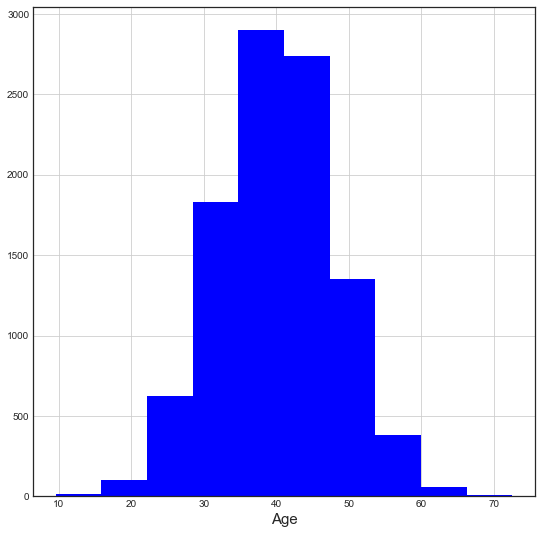

In [4]:
age = np.random.normal(40, 8, N)  # X in the lecture slides
plt.hist(age, color="blue")
plt.xlabel("Age")
plt.show()

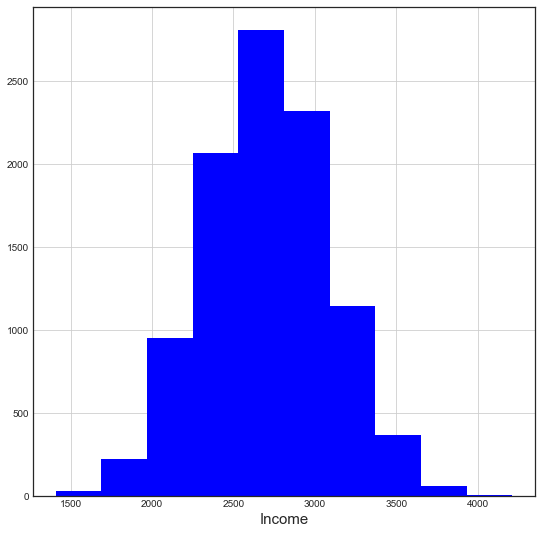

In [5]:
income = (
    a_income + b_age * age + scale_eps * np.random.normal(mean_eps, sd_eps, N)
)  # Y in the lecture slides
plt.hist(income, color="blue")
plt.xlabel("Income")
plt.show()

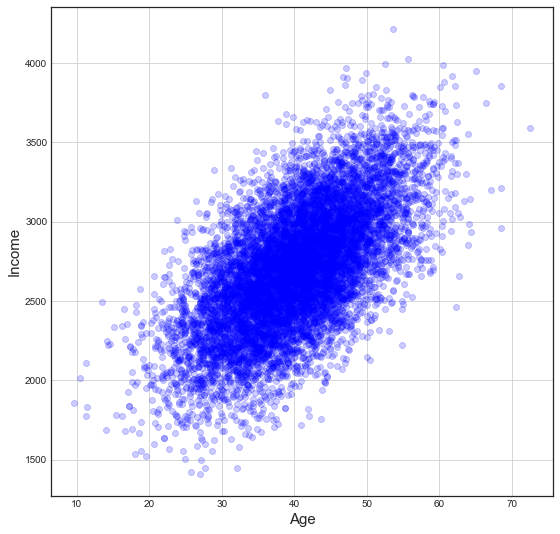

In [6]:
_ = plt.scatter(age, income, alpha=0.2, c="blue")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

In [7]:
another_variable = np.random.uniform(0, 1, N)  # Z in the lecture slides

In [8]:
df = pd.DataFrame(
    {
        "age": age,
        "income": income,
        "another_variable": another_variable,
    }
)

## Create data sets with missing observations

In [9]:
# missingness is completely random
mcar_df = df.copy()
mcar_df.loc[mcar_df["another_variable"] < 0.2, "income"] = np.NaN
mcar_df["missingness"] = "mcar"

In [10]:
# missingness depends on x
mar_df = df.copy()
mar_df.loc[mcar_df["age"] > 50, "income"] = np.NaN
mar_df["missingness"] = "mar"

In [11]:
# missingness depends on y
mnar_df = df.copy()
mnar_df.loc[mnar_df["income"] < 2_500, "income"] = np.NaN
mnar_df["missingness"] = "mnar"

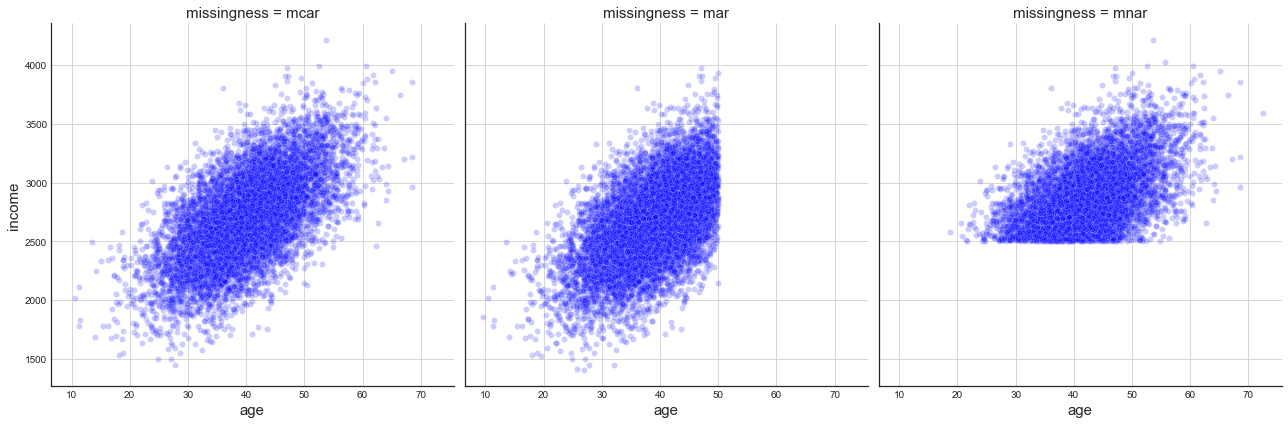

In [12]:
g = sns.FacetGrid(pd.concat([mcar_df, mar_df, mnar_df]), col="missingness", height=6)
g.map(sns.scatterplot, "age", "income", alpha=0.2, color="blue")
plt.show()

What do you think will happen when we use our different imputation strategies for the different missingness cases?

|      | <div style="width:120px">Mean</div> | <div style="width:120px">Linear Model</div> | <div style="width:120px">Linear Model + Noise</div> |
| ---- | :---: | :---: | :--: |
| MCAR | ? | ? | ? |
| MAR  | ? | ? | ? |
| MNAR | ? | ? | ? |

## Mising completely at random (MCAR)

### Helper function

In [13]:
def impute_lm(data, kind="mean", noise=False):
    """
    This function does three things:
      1. impute missing observations: mean, linear model, or linear model
      2. add noise to imputed values
      3. plot observed and imputed values
    """

    # avoid side effects
    out = data.copy()

    # impute with mean
    if kind == "mean":
        out["income_hat"] = data["income"].mean()

    # impute with regression
    elif kind == "lm":
        model_income_age = smf.ols(
            formula="income ~ age", data=data[data["income"].notnull()]
        )
        result_model_income_age = model_income_age.fit()
        out["income_hat"] = result_model_income_age.predict(data)

    # add noise (sampled from residuals) to regression prediction
    if noise:
        out["income_hat"] += np.random.choice(
            result_model_income_age.resid, out.shape[0]
        )

    # plot
    out["imp"] = out["income"].isnull().astype(int)
    out_obs = out[out["imp"] == 0]
    plt.figure()
    # observed vaues
    plt.scatter(
        out_obs["age"], out_obs["income"], alpha=0.2, c="blue", label="Observed"
    )
    # imputed (= missing) values
    if kind != "none":
        out["income_imp_reg"] = out["income"].fillna(out["income_hat"])
        out_miss = out[out["imp"] == 1]
        plt.scatter(
            out_miss["age"],
            out_miss["income_imp_reg"],
            alpha=0.2,
            c="darkorange",
            label="Missing",
        )
    # style plot
    plt.legend(loc="upper left")
    plt.xlabel("Age")
    plt.ylabel("Income")
    plt.xlim(5, 75)
    plt.ylim(1_000, 4_500)

### Impute with mean

Not wrong, but not clever either.

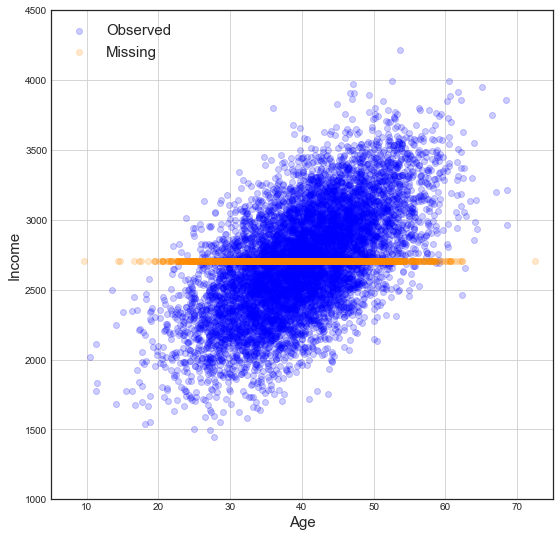

In [14]:
impute_lm(mcar_df, kind="mean", noise=False)

### Impute with regression

Much better.

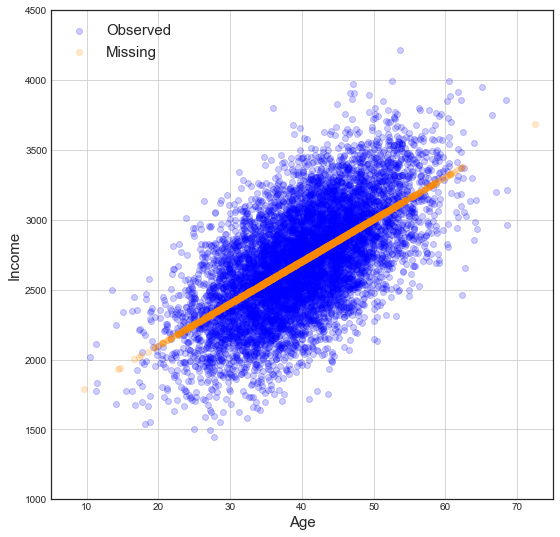

In [15]:
impute_lm(mcar_df, kind="lm", noise=False)

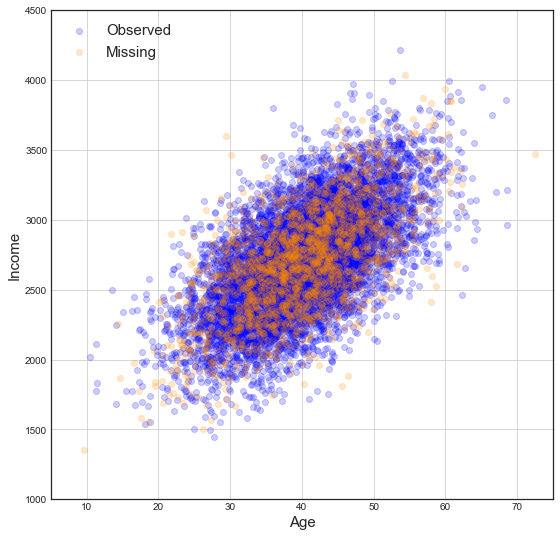

In [16]:
impute_lm(mcar_df, kind="lm", noise=True)

## MAR

### Impute with mean

That does not look good, values are too low!

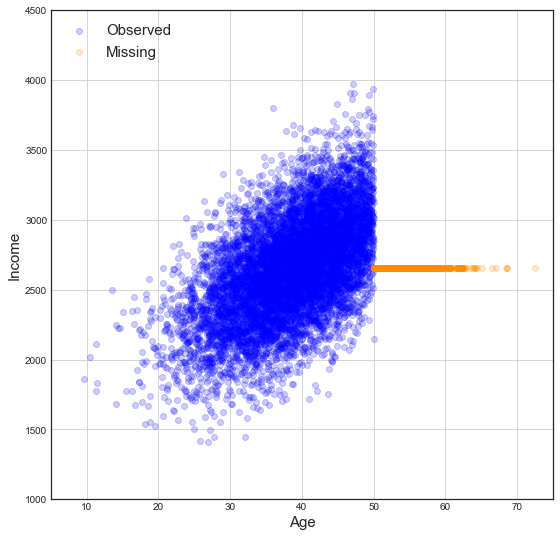

In [17]:
impute_lm(mar_df, kind="mean", noise=False)

### Impute with regression

That looks good.

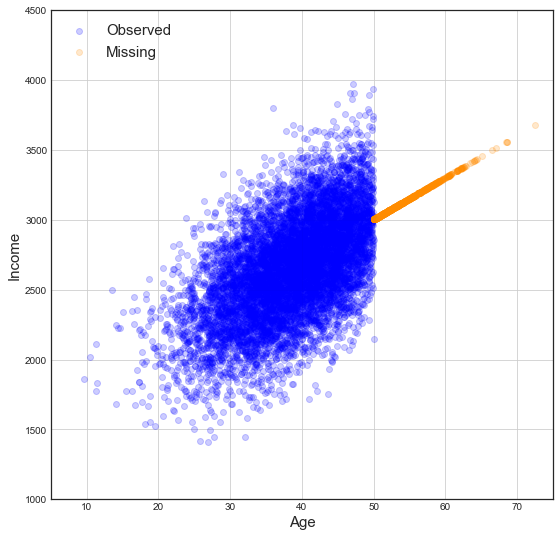

In [18]:
impute_lm(mar_df, kind="lm", noise=False)

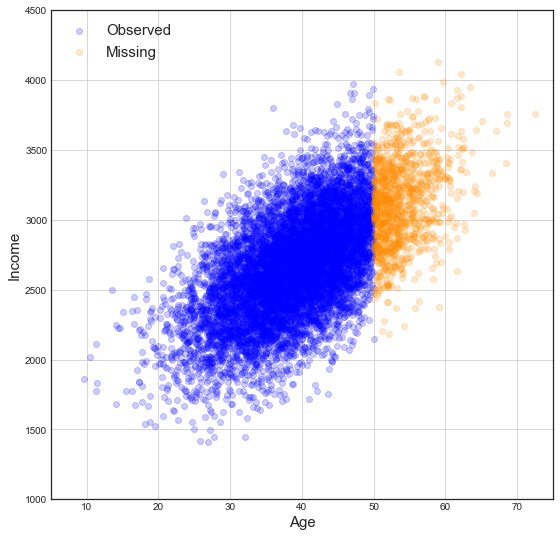

In [19]:
impute_lm(mar_df, kind="lm", noise=True)

## MNAR

All naïve imputation strategies fail, we need more complex methods that specifically account for the fact that the probability of missingness depends on Y (beyond the scope of this course, see econometrics courses).

### No imputation

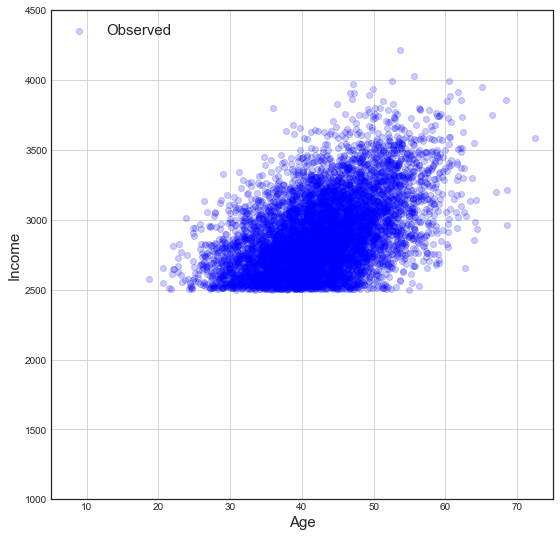

In [20]:
impute_lm(mnar_df, kind="none", noise=False)

### Impute with mean

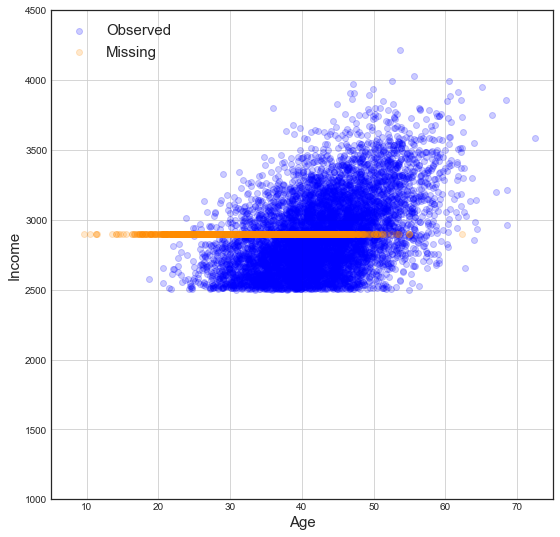

In [21]:
impute_lm(mnar_df, kind="mean", noise=False)

### Impute with regression

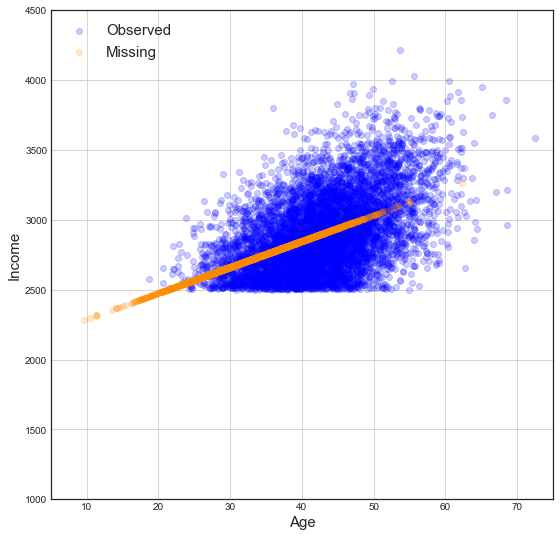

In [22]:
impute_lm(mnar_df, kind="lm", noise=False)

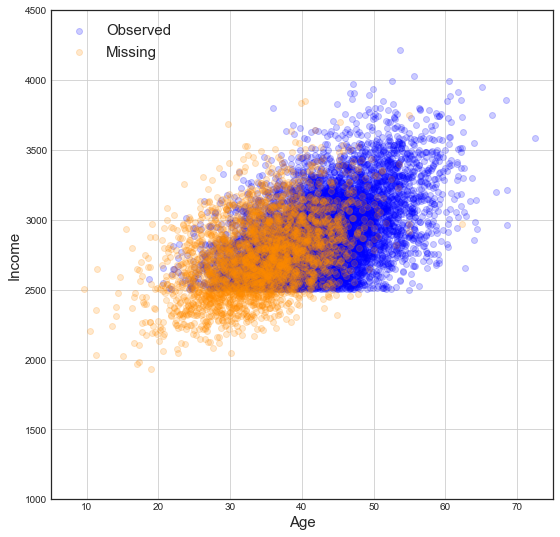

In [23]:
impute_lm(mnar_df, kind="lm", noise=True)

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 2, Lecture 05 <br>
2021/22 <br>